Assignment 3

In [1]:
import urllib.request

# Define the download URL and target path
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
target_path = "cifar10.tgz"

# Download the dataset
urllib.request.urlretrieve(dataset_url, target_path)

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [2]:
import tarfile

# Extract the downloaded file
with tarfile.open(target_path) as tar:
    tar.extractall()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [3]:
# Keeping the three classes and deleting the rest
import shutil
import os
path= "cifar10"
data_dir =path
dir_list= ['train','test']


In [4]:
# keep 300 images from each folder
import random
for root, dirs, files in os.walk(path):
    #print(root)

    for file in files:
        if file.endswith(".png"):
            directory_path = os.path.join(root)
            #print(directory_path)
            all_files = os.listdir(directory_path)
            #print(all_files)
            random.shuffle(all_files)
            files_to_keep = all_files[:300]
            for f in all_files:
                if f not in files_to_keep:
                    os.remove(os.path.join(directory_path, f))

In [5]:
# merging the dataset train and test into one directory

# Define paths


classes= ['airplane', 'cat', 'deer', 'dog', 'frog']

for klass in classes:
  if not os.path.exists(os.path.join(path,klass)):
      os.makedirs(os.path.join(path,klass))

for dir in dir_list:
    for klass in classes:
      for file in os.listdir(os.path.join(path,dir,klass)):
        shutil.copy(os.path.join(path,dir,klass,file), os.path.join(path,klass))




In [6]:

# Delete the extracted folder
for dir in dir_list:
     shutil.rmtree(os.path.join(path,dir))

print("Folder deleted successfully!")

Folder deleted successfully!


In [7]:
# Count images and print size
total_images = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust for your image formats
            total_images += 1
            image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)


Total images downloaded: 2923


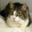

In [8]:
import pathlib
from PIL import Image

cat_path = pathlib.Path(data_dir) / "cat"  # Ensure correct path using pathlib
cat_imgs = list(cat_path.glob('*.png'))  # Adjust file extension if needed

Image.open(str(cat_imgs[0]))

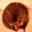

In [9]:
Image.open(str(cat_imgs[7]))

In [10]:
batch_size = 32

In [11]:
#os.listdir(data_dir)
#os.remove(os.path.join(data_dir, '.ipynb_checkpoints'))

In [33]:
from torchvision import datasets, transforms

# 1. Load the dataset
data_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Rescale
])

In [34]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(data_dir, transform = data_transform)

train_size = int(0.8 * len(dataset))  # Calculate 80% of dataset size
val_size = len(dataset) - train_size  # Calculate 20% of dataset size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [35]:
dataset

Dataset ImageFolder
    Number of datapoints: 2923
    Root location: cifar10
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [36]:
print(len(train_dataset))
print(len(val_dataset))

2338
585


In [37]:
class_names = dataset.classes
print(class_names)

['airplane', 'cat', 'deer', 'dog', 'frog']


In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

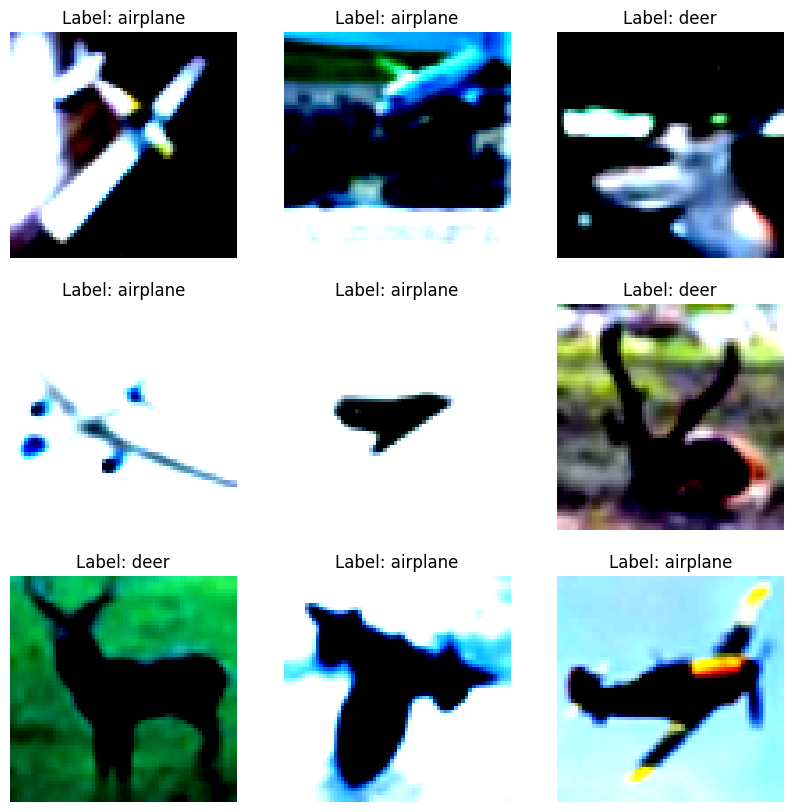

In [39]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()


In [40]:
for image_batch, labels_batch in train_dataloader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [41]:
print(len(train_dataloader.dataset))
print(train_dataloader.dataset[0][0].shape)
print(train_dataloader.dataset[1][0].shape)

2338
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


In [50]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        # Corrected input size for the first fully connected layer
        self.fc1 = nn.Linear(2304, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x


# Instantiate the model
num_classes = 5
model = CustomModel(num_classes)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model architecture
print(model)


CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)


In [51]:
import torch.optim as optim
import torch.nn.functional as F

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the metrics (accuracy)
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Define the training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            images = images.to(device)  # Move input data to GPU
            labels = labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 25  # Choose the number of epochs
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/25, Loss: 1.4775, Accuracy: 0.3482
Epoch 2/25, Loss: 1.3138, Accuracy: 0.4303
Epoch 3/25, Loss: 1.1935, Accuracy: 0.4949
Epoch 4/25, Loss: 1.1238, Accuracy: 0.5393
Epoch 5/25, Loss: 1.1062, Accuracy: 0.5492
Epoch 6/25, Loss: 1.0150, Accuracy: 0.5817
Epoch 7/25, Loss: 0.9886, Accuracy: 0.6009
Epoch 8/25, Loss: 0.9405, Accuracy: 0.6347
Epoch 9/25, Loss: 0.9542, Accuracy: 0.6193
Epoch 10/25, Loss: 0.8544, Accuracy: 0.6506
Epoch 11/25, Loss: 0.8105, Accuracy: 0.6903
Epoch 12/25, Loss: 0.7318, Accuracy: 0.7143
Epoch 13/25, Loss: 0.7069, Accuracy: 0.7284
Epoch 14/25, Loss: 0.6513, Accuracy: 0.7532
Epoch 15/25, Loss: 0.6035, Accuracy: 0.7720
Epoch 16/25, Loss: 0.5061, Accuracy: 0.8131
Epoch 17/25, Loss: 0.4824, Accuracy: 0.8242
Epoch 18/25, Loss: 0.4165, Accuracy: 0.8512
Epoch 19/25, Loss: 0.3471, Accuracy: 0.8666
Epoch 20/25, Loss: 0.3016, Accuracy: 0.8862
Epoch 21/25, Loss: 0.2588, Accuracy: 0.9080
Epoch 22/25, Loss: 0.2402, Accuracy: 0.9098
Epoch 23/25, Loss: 0.1957, Accuracy: 0.93

In [52]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for images, labels in val_dataloader:  # Assuming you have a DataLoader named 'val_dataloader'
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        # Assuming class_names is a list containing class labels
        predicted_classes = [classes[torch.argmax(prob).item()] for prob in probabilities]

        # Print predictions for each sample in the batch
        for i in range(5):
            predicted_class = predicted_classes[i]
            confidence = torch.max(probabilities[i]).item()
            true_class = classes[labels[i].item()]

            print(f"Predicted: {predicted_class}, True: {true_class}, Confidence: {confidence*100:.2f}%")

Predicted: dog, True: dog, Confidence: 99.30%
Predicted: airplane, True: airplane, Confidence: 75.91%
Predicted: deer, True: frog, Confidence: 97.94%
Predicted: frog, True: frog, Confidence: 99.57%
Predicted: dog, True: dog, Confidence: 82.74%
Predicted: frog, True: cat, Confidence: 90.21%
Predicted: deer, True: cat, Confidence: 55.69%
Predicted: airplane, True: deer, Confidence: 93.06%
Predicted: deer, True: frog, Confidence: 93.13%
Predicted: dog, True: cat, Confidence: 55.69%
Predicted: airplane, True: deer, Confidence: 71.43%
Predicted: airplane, True: airplane, Confidence: 100.00%
Predicted: dog, True: dog, Confidence: 86.58%
Predicted: cat, True: cat, Confidence: 99.98%
Predicted: cat, True: cat, Confidence: 68.62%
Predicted: frog, True: frog, Confidence: 68.86%
Predicted: airplane, True: airplane, Confidence: 98.47%
Predicted: deer, True: dog, Confidence: 39.93%
Predicted: deer, True: deer, Confidence: 99.38%
Predicted: dog, True: frog, Confidence: 55.66%
Predicted: dog, True: d

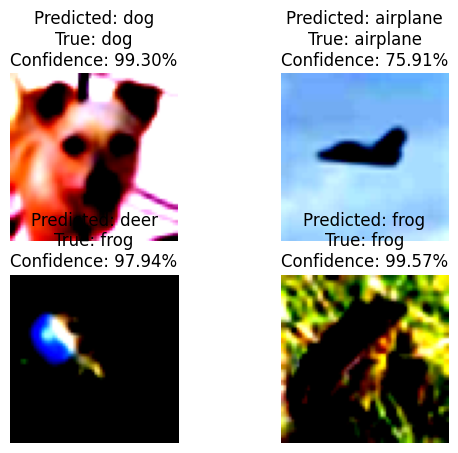

In [53]:
model.eval()

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_dataloader):
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        # Assuming class_names is a list containing class labels
        predicted_classes = [classes[torch.argmax(prob).item()] for prob in probabilities]

        # Print predictions for each sample in the batch (show only 4)
        for i in range(4):
            image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
            true_class = classes[labels[i].item()]
            predicted_class = predicted_classes[i]
            confidence = torch.max(probabilities[i]).item()

            # Visualize the image and its prediction
            plt.subplot(2, 2, i+1)
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}\nConfidence: {confidence*100:.2f}%")
            plt.axis('off')

        plt.show()  # Display the batch of images with predictions

        if batch_idx == 0:
            break  # Only visualize the first batch

# Load pre-trained GoogleNet (InceptionNet)


In [54]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=True)
batch_size = 32  # Choose your desired batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [55]:

# Freeze all layers except the final classification layer
for name, param in googlenet.named_parameters():
    if "fc" not in name:  # Freeze all layers except the final classification layer
        param.requires_grad = False



In [56]:
# Modify the final classification layer
num_classes = len(train_dataset.dataset.classes)
print(num_classes)
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, num_classes)


5


In [57]:

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

In [49]:



# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)  # Use all parameters

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1/25, Loss: 1.3907, Accuracy: 0.4192
Epoch 2/25, Loss: 1.0716, Accuracy: 0.6074
Epoch 3/25, Loss: 0.9915, Accuracy: 0.6373
Epoch 4/25, Loss: 0.9494, Accuracy: 0.6441
Epoch 5/25, Loss: 0.9097, Accuracy: 0.6591
Epoch 6/25, Loss: 0.8844, Accuracy: 0.6715
Epoch 7/25, Loss: 0.8745, Accuracy: 0.6788
Epoch 8/25, Loss: 0.8461, Accuracy: 0.6882
Epoch 9/25, Loss: 0.8557, Accuracy: 0.6758
Epoch 10/25, Loss: 0.8161, Accuracy: 0.6950
Epoch 11/25, Loss: 0.8170, Accuracy: 0.6920
Epoch 12/25, Loss: 0.7862, Accuracy: 0.7023
Epoch 13/25, Loss: 0.8232, Accuracy: 0.6792
Epoch 14/25, Loss: 0.8307, Accuracy: 0.6873
Epoch 15/25, Loss: 0.7952, Accuracy: 0.7057
Epoch 16/25, Loss: 0.8033, Accuracy: 0.6899
Epoch 17/25, Loss: 0.7657, Accuracy: 0.7143
Epoch 18/25, Loss: 0.8099, Accuracy: 0.6891
Epoch 19/25, Loss: 0.7984, Accuracy: 0.6946
Epoch 20/25, Loss: 0.7786, Accuracy: 0.7062
Epoch 21/25, Loss: 0.7890, Accuracy: 0.6912
Epoch 22/25, Loss: 0.7576, Accuracy: 0.7070
Epoch 23/25, Loss: 0.7975, Accuracy: 0.70

###### When comparing the accuracy of the customized CNN model(81%) with that of GoogleNet (71%), the customized CNN model shows a greater accuracy. However, it is important to note that the GoogleNet model has its own limitations when it comes to achieving high accuracy. One of the main limitations is its reliance on a fixed architecture, which may not be suitable for all types of data or tasks. Additionally, the GoogleNet model may struggle with capturing fine-grained details and subtle features in complex datasets, leading to lower accuracy compared to a customized CNN model.